In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from prophet import Prophet

In [2]:
# !pip install yfinance prophet

In [3]:
# Read the data
data = pd.read_csv("dataset_mood_smartphone.csv",delimiter=',')
# drop a column
data = data.drop(['Unnamed: 0'],axis=1)
# print the data
data

,id,time,variable,value
0,AS14.01,2014-02-26 13:00:00.000,mood,6.000
1,AS14.01,2014-02-26 15:00:00.000,mood,6.000
2,AS14.01,2014-02-26 18:00:00.000,mood,6.000
3,AS14.01,2014-02-26 21:00:00.000,mood,7.000
4,AS14.01,2014-02-27 09:00:00.000,mood,6.000
...,...,...,...,...
376907,AS14.30,2014-04-11 07:51:16.948,appCat.weather,8.032
376908,AS14.30,2014-04-19 11:00:32.747,appCat.weather,3.008
376909,AS14.30,2014-04-26 10:19:07.434,appCat.weather,7.026
376910,AS14.30,2014-04-27 00:44:48.450,appCat.weather,23.033


In [4]:
# convert time column to datetime
data['time'] = pd.to_datetime(data['time'])

# create a new column 'monthly_date' with monthly date values
data['date'] = data['time'].dt.to_period('d')

In [5]:
cat1 = data[data['variable'].isin(['activity','call','sms'])].reset_index(drop=True)
cat2 = data[np.logical_not(data['variable'].isin(['activity','call','sms']))].reset_index(drop=True)

agg_cat1 = cat1.groupby(['id','variable','date']).median().reset_index()
agg_cat2 = cat2.groupby(['id','variable','date']).mean().reset_index()

data_agg = pd.concat([agg_cat1, agg_cat2], axis=0)

data_agg.reset_index(inplace=True, drop=True)
data_agg

,id,variable,date,value
0,AS14.01,activity,2014-03-20,0.081548
1,AS14.01,activity,2014-03-21,0.032787
2,AS14.01,activity,2014-03-22,0.260593
3,AS14.01,activity,2014-03-23,0.139130
4,AS14.01,activity,2014-03-24,0.041949
...,...,...,...,...
15517,AS14.33,screen,2014-05-26,300.399810
15518,AS14.33,screen,2014-05-27,113.607750
15519,AS14.33,screen,2014-05-28,113.657683
15520,AS14.33,screen,2014-05-29,118.978033


In [6]:
data_agg['value'].sum()

473829.24040304136

In [7]:
# Some pre-processing
df = pd.pivot_table(data_agg, values='value', index=['id', 'date'], columns='variable').reset_index()
df

variable,id,date,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,...,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms
0,AS14.01,2014-02-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,AS14.01,2014-02-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,AS14.01,2014-02-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0
3,AS14.01,2014-02-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0
4,AS14.01,2014-02-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1968,AS14.33,2014-05-27,0.000000,8.545776,59.382943,62.347000,NaN,NaN,NaN,17.835750,...,NaN,NaN,18.724333,NaN,1.0,-0.600000,0.4,6.2,113.607750,1.0
1969,AS14.33,2014-05-28,0.004202,9.590398,37.238750,43.907571,NaN,NaN,44.738625,27.891895,...,NaN,NaN,5.111000,NaN,1.0,0.000000,1.2,8.2,113.657683,1.0
1970,AS14.33,2014-05-29,0.000000,6.452161,54.388125,68.369000,NaN,NaN,NaN,9.734000,...,0.939000,NaN,1.599500,NaN,1.0,-1.333333,1.0,7.0,118.978033,1.0
1971,AS14.33,2014-05-30,0.035714,14.776845,46.412278,37.174286,NaN,NaN,NaN,10.522000,...,37.594571,2.690667,15.521667,NaN,1.0,-0.800000,-0.4,6.8,86.342245,NaN


In [212]:
# df['call'].fillna(0, inplace=True)
# df['sms'].fillna(0, inplace=True)

## Task 1A

Start with exploring the raw data that is available:

• Notice all sorts of properties of the dataset: how many records are there, how many
attributes, what kinds of attributes are there, ranges of values, distribution of values,
relationships between attributes, missing values, and so on. A table is often a suitable
way of showing such properties of a dataset. Notice if something is interesting (to you,
or in general), make sure you write it down if you find something worth mentioning.

• Make various plots of the data. Is there something interesting worth reporting? Report
the figures, discuss what is in them. What meaning do those bars, lines, dots, etc.
convey? Please select essential and interesting plots for discussion, as you have limited
space for reporting your findings.


## Remaining
Remaining - im still not able to find a good graph to showcase in this. 
Gowthams comment - most entries of appCat have a mood valence associated with its usage. 

In [213]:
df.columns

Index(['id', 'date', 'activity', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.finance', 'appCat.game',
       'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
       'appCat.unknown', 'appCat.utilities', 'appCat.weather', 'call',
       'circumplex.arousal', 'circumplex.valence', 'mood', 'screen', 'sms'],
      dtype='object', name='variable')

In [214]:
# print the number of records and attributes
print(f'Number of records: {df.shape[0]}')
print(f'Number of attributes: {df.shape[1]}')

# print the names and data types of the attributes
print('Attribute names and data types:')
print(df.dtypes)

# # get the range of values for the 'value' column
# value_range = (df['value'].min(), df['value'].max())
# print('Range of Value column:', value_range)

# get the range of values for the 'time' column
time_range = (df['date'].min(), df['date'].max())
print('Range of Time column:', time_range)

# print the number of missing values for each attribute
print('Number of missing values per attribute:')
print(df.isnull().sum())

Number of records: 1973
Number of attributes: 21
Attribute names and data types:
variable
id                         object
date                    period[D]
activity                  float64
appCat.builtin            float64
appCat.communication      float64
appCat.entertainment      float64
appCat.finance            float64
appCat.game               float64
appCat.office             float64
appCat.other              float64
appCat.social             float64
appCat.travel             float64
appCat.unknown            float64
appCat.utilities          float64
appCat.weather            float64
call                      float64
circumplex.arousal        float64
circumplex.valence        float64
mood                      float64
screen                    float64
sms                       float64
dtype: object
Range of Time column: (Period('2014-02-17', 'D'), Period('2014-06-09', 'D'))
Number of missing values per attribute:
variable
id                         0
date                       

In [215]:
df.describe()

variable,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms
count,1188.000000,1195.000000,1183.000000,850.000000,207.000000,193.000000,276.000000,1120.000000,988.000000,429.000000,264.000000,433.000000,113.000000,1338.0,1268.000000,1266.000000,1268.000000,1207.000000,734.0
mean,0.062369,25.076675,45.498456,94.665520,25.664965,156.057124,42.614881,21.479152,76.848889,52.768936,63.136312,17.351448,21.553481,1.0,-0.103851,0.687112,6.990063,84.004342,1.0
std,0.101016,79.059608,36.902552,148.204684,24.707236,256.227701,105.578637,40.505653,140.408015,98.087529,169.998827,31.478982,20.750719,0.0,0.662715,0.434602,0.736465,70.113351,0.0
min,0.000000,-772.768558,1.095000,1.014000,1.004000,1.010000,0.044000,2.007000,0.725000,0.080000,0.111000,1.002000,1.007000,1.0,-2.000000,-1.250000,3.000000,0.462000,1.0
25%,0.000000,7.977571,27.142218,15.931885,8.867354,30.036571,6.679625,9.063450,31.390375,22.850333,12.828125,4.684000,9.393667,1.0,-0.600000,0.400000,6.600000,44.920734,1.0
50%,0.020921,12.535062,38.598403,47.289179,17.149000,59.937667,17.065125,12.051500,54.075359,37.994000,25.623857,9.065000,16.795000,1.0,0.000000,0.800000,7.000000,65.307625,1.0
75%,0.070833,21.143343,52.594775,111.764744,32.235667,183.659667,40.523500,18.508375,91.634626,59.765000,48.554021,19.125000,26.735000,1.0,0.400000,1.000000,7.500000,97.565377,1.0
max,0.611111,1399.054714,522.718000,1650.744000,149.181000,2562.907000,1494.864000,722.752200,3759.177625,1758.019333,2239.937000,363.429000,183.468500,1.0,2.000000,2.000000,9.333333,960.503111,1.0


In [216]:
df.shape

(1973, 21)

In [217]:
#number of unique values
df.nunique()

variable
id                        27
date                     113
activity                 565
appCat.builtin          1195
appCat.communication    1183
appCat.entertainment     849
appCat.finance           207
appCat.game              191
appCat.office            275
appCat.other            1115
appCat.social            988
appCat.travel            429
appCat.unknown           264
appCat.utilities         424
appCat.weather           112
call                       1
circumplex.arousal        42
circumplex.valence        30
mood                      59
screen                  1207
sms                        1
dtype: int64

In [218]:
#skewness and kurtosis
print("Skewness: %f" % df['mood'].skew())
print("Kurtosis: %f" % df['mood'].kurt())

Skewness: -0.801037
Kurtosis: 2.588625


<AxesSubplot:xlabel='date'>

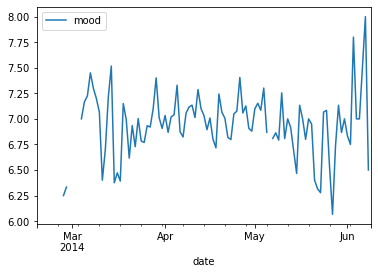

In [221]:
data_monthly = df.loc[:, df.columns != 'id']
grouped_data = data_monthly.groupby(['date']).mean().reset_index()
grouped_data.plot(x='date', y='mood', kind='line')

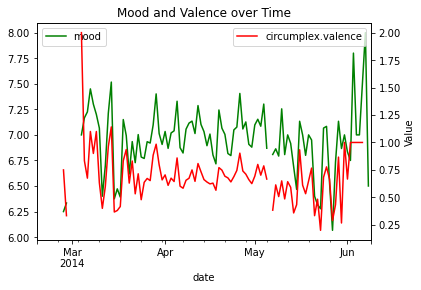

In [245]:

# create plot with secondary axis for 'B' column
ax1 = grouped_data.plot(x='date', y='mood', color='green')
ax2 = ax1.twinx()
grouped_data.plot(x='date', y='circumplex.valence', ax=ax2, color='red')

# add a title and axis labels
plt.title('Mood and Valence over Time')
plt.xlabel('Time')
plt.ylabel('Value')

# show the plot
plt.show()


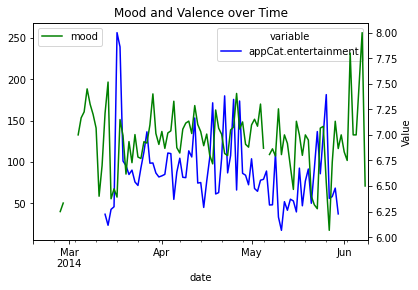

In [237]:
# create plot with secondary axis for 'B' column
ax1 = grouped_data.plot(x='date', y=['appCat.entertainment'], color='blue')
ax2 = ax1.twinx()
grouped_data.plot(x='date', y='mood', ax=ax2, color='green')

# add a title and axis labels
plt.title('Mood and Valence over Time')
plt.xlabel('Time')
plt.ylabel('Value')

# show the plot
plt.show()

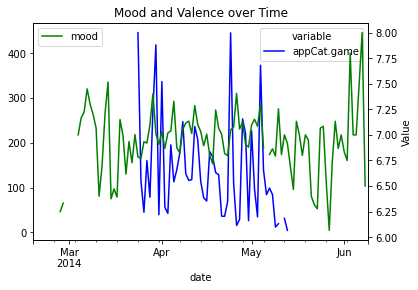

In [236]:
# create plot with secondary axis for 'B' column
ax1 = grouped_data.plot(x='date', y=['appCat.game'], color='blue')
ax2 = ax1.twinx()
grouped_data.plot(x='date', y='mood', ax=ax2, color='green')

# add a title and axis labels
plt.title('Mood and Valence over Time')
plt.xlabel('Time')
plt.ylabel('Value')

# show the plot
plt.show()

In [110]:
# something interesting is that there are some duplicated timestamp need to explore more on that
# there is a negative value on one day throughout a dataset, huge value.
# some values are even missing. 

In [111]:
# # group the data by participant and time, and calculate the mean mood value for each group
# grouped = df.groupby(['variable']).mean().reset_index()

# print(grouped.sort_values('value',ascending=False))

In [112]:
#this shows that poeple have spend time on games more (Duration of usage of game apps (time))

In [113]:
# data_monthly = df[['time','value']]
# # create a new column 'monthly_date' with monthly date values
# data_monthly['monthly_date'] = data_monthly['time'].dt.to_period('M')
# grouped_time_monthly = data_monthly.groupby(['monthly_date']).sum().reset_index()
# print(grouped_time_monthly.sort_values('value',ascending=False))

In [114]:
# this shows in 2014 April the value is highest.

In [115]:
# # # plot a line graph of 'value' vs 'time'
# grouped_time_monthly.plot(x='monthly_date', y='value', kind='line')

# # show the plot
# plt.show()

In [188]:
# sns.heatmap(df.corr());

In [ ]:
# from this we can conclude that valence has an effect on the mood.

# Task 1B


As the insights from Task 1A will have shown, the dataset you analyze contains quite some
noise. Values are sometimes missing, and extreme or incorrect values are seen that are likely
outliers youmay want to remove from the dataset. We will clean the dataset in two steps:

• Apply an approach to remove extreme and incorrect values fromyour dataset. Describe
what your approach is, why you consider that to be a good approach, and describe what
the result of applying the approach is.

• Impute the missing values using two different approaches. Describe the approaches
and study the impact of applying them to your data. Argue which one of the two approacheswould
be most suitable and select that one to formyour cleaned dataset. Also
base yourself on scientific literature for making your choice.
Advanced: The advanced dataset contains a number of time series, select approaches to impute
missing values that are logical for such time series. Also consider what to do with prolonged
periods of missing data in a time series.

In [8]:
df

variable,id,date,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,...,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms
0,AS14.01,2014-02-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,AS14.01,2014-02-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,AS14.01,2014-02-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0
3,AS14.01,2014-02-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0
4,AS14.01,2014-02-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1968,AS14.33,2014-05-27,0.000000,8.545776,59.382943,62.347000,NaN,NaN,NaN,17.835750,...,NaN,NaN,18.724333,NaN,1.0,-0.600000,0.4,6.2,113.607750,1.0
1969,AS14.33,2014-05-28,0.004202,9.590398,37.238750,43.907571,NaN,NaN,44.738625,27.891895,...,NaN,NaN,5.111000,NaN,1.0,0.000000,1.2,8.2,113.657683,1.0
1970,AS14.33,2014-05-29,0.000000,6.452161,54.388125,68.369000,NaN,NaN,NaN,9.734000,...,0.939000,NaN,1.599500,NaN,1.0,-1.333333,1.0,7.0,118.978033,1.0
1971,AS14.33,2014-05-30,0.035714,14.776845,46.412278,37.174286,NaN,NaN,NaN,10.522000,...,37.594571,2.690667,15.521667,NaN,1.0,-0.800000,-0.4,6.8,86.342245,NaN


In [9]:
# # rename the other columns
# df = df.rename(columns={
#     'date': 'ds',
#     'mood': 'y',
# })

In [10]:
# df = df.set_index(['ds', 'y']).sort_index().reset_index()
# df

In [11]:
# df.info()

In [12]:
# df['ds'] = df['ds'].dt.to_timestamp(None)

In [13]:
# # Add seasonality
# model = Prophet()
# # Fit the model on the training dataset
# model.fit(df)

In [14]:
# forecast = model.predict(df)
# performance = pd.merge(df, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

In [15]:
# performance

In [16]:
# # Create an anomaly indicator
# performance['anomaly'] = performance.apply(lambda rows: 1 if ((rows.y<rows.yhat_lower)|(rows.y>rows.yhat_upper)) else 0, axis = 1)
# # Check the number of anomalies
# performance['anomaly'].value_counts()

In [17]:
# performance

In [18]:
# # Take a look at the anomalies
# anomalies = performance[performance['anomaly']==1].sort_values(by='ds')
# anomalies

In [19]:
# Visualize the anomalies
# sns.scatterplot(x='ds', y='y', data=performance, hue='anomaly')

In [20]:
from sklearn.impute import KNNImputer
# Define a function to apply KNN imputation
def knn_imputation(df, column_name):
    # Create a copy of the dataframe
    df_imputed = df.copy()

    # Create a KNN imputer object
    imputer = KNNImputer(n_neighbors=5)

    # Fit and transform the data
    df_imputed[column_name] = imputer.fit_transform(df[[column_name]])

    return df_imputed

In [21]:
df_m1 = df.copy()
for column in df_m1.columns:
    print(column)
    temp = df_m1[column].isnull().any()
    if temp == True:
        df_imputed = knn_imputation(df_m1, column)
        df_m1[column] = df_imputed[column]
    else:
        continue

id
date
activity
appCat.builtin
appCat.communication
appCat.entertainment
appCat.finance
appCat.game
appCat.office
appCat.other
appCat.social
appCat.travel
appCat.unknown
appCat.utilities
appCat.weather
call
circumplex.arousal
circumplex.valence
mood
screen
sms


In [22]:
df_m1

variable,id,date,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,...,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms
0,AS14.01,2014-02-17,0.062369,25.076675,45.498456,94.665520,25.664965,156.057124,42.614881,21.479152,...,52.768936,63.136312,17.351448,21.553481,1.0,-0.103851,0.687112,6.990063,84.004342,1.0
1,AS14.01,2014-02-18,0.062369,25.076675,45.498456,94.665520,25.664965,156.057124,42.614881,21.479152,...,52.768936,63.136312,17.351448,21.553481,1.0,-0.103851,0.687112,6.990063,84.004342,1.0
2,AS14.01,2014-02-19,0.062369,25.076675,45.498456,94.665520,25.664965,156.057124,42.614881,21.479152,...,52.768936,63.136312,17.351448,21.553481,1.0,-0.103851,0.687112,6.990063,84.004342,1.0
3,AS14.01,2014-02-20,0.062369,25.076675,45.498456,94.665520,25.664965,156.057124,42.614881,21.479152,...,52.768936,63.136312,17.351448,21.553481,1.0,-0.103851,0.687112,6.990063,84.004342,1.0
4,AS14.01,2014-02-21,0.062369,25.076675,45.498456,94.665520,25.664965,156.057124,42.614881,21.479152,...,52.768936,63.136312,17.351448,21.553481,1.0,-0.103851,0.687112,6.990063,84.004342,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1968,AS14.33,2014-05-27,0.000000,8.545776,59.382943,62.347000,25.664965,156.057124,42.614881,17.835750,...,52.768936,63.136312,18.724333,21.553481,1.0,-0.600000,0.400000,6.200000,113.607750,1.0
1969,AS14.33,2014-05-28,0.004202,9.590398,37.238750,43.907571,25.664965,156.057124,44.738625,27.891895,...,52.768936,63.136312,5.111000,21.553481,1.0,0.000000,1.200000,8.200000,113.657683,1.0
1970,AS14.33,2014-05-29,0.000000,6.452161,54.388125,68.369000,25.664965,156.057124,42.614881,9.734000,...,0.939000,63.136312,1.599500,21.553481,1.0,-1.333333,1.000000,7.000000,118.978033,1.0
1971,AS14.33,2014-05-30,0.035714,14.776845,46.412278,37.174286,25.664965,156.057124,42.614881,10.522000,...,37.594571,2.690667,15.521667,21.553481,1.0,-0.800000,-0.400000,6.800000,86.342245,1.0


In [23]:
for column in df_m1.columns:
    temp = df_m1[column].isnull().any()
    if temp == True:
        print(column)

In [25]:
df_m2 = df.copy()
df_m2 = df_m2.set_index('date')
# Imputing with linear interpolation
df_m2 = df_m2.interpolate(method='time',limit_direction='both')

df_m2

variable,id,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms
date,,,,,,,,,,,,,,,,,,,,
2014-02-17,AS14.01,0.145299,14.101000,30.734167,36.754000,8.038400,31.647,17.086000,26.106875,33.491833,81.783286,25.749571,13.062000,3.020000,1.0,-0.250000,0.75,6.25,83.482467,1.0
2014-02-18,AS14.01,0.145299,14.101000,30.734167,36.754000,8.038400,31.647,17.086000,26.106875,33.491833,81.783286,25.749571,13.062000,3.020000,1.0,-0.250000,0.75,6.25,83.482467,1.0
2014-02-19,AS14.01,0.145299,14.101000,30.734167,36.754000,8.038400,31.647,17.086000,26.106875,33.491833,81.783286,25.749571,13.062000,3.020000,1.0,-0.250000,0.75,6.25,83.482467,1.0
2014-02-20,AS14.01,0.145299,14.101000,30.734167,36.754000,8.038400,31.647,17.086000,26.106875,33.491833,81.783286,25.749571,13.062000,3.020000,1.0,-0.250000,0.75,6.25,83.482467,1.0
2014-02-21,AS14.01,0.145299,14.101000,30.734167,36.754000,8.038400,31.647,17.086000,26.106875,33.491833,81.783286,25.749571,13.062000,3.020000,1.0,-0.250000,0.75,6.25,83.482467,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-05-27,AS14.33,0.000000,8.545776,59.382943,62.347000,21.777667,4.693,87.634312,17.835750,50.259100,64.526444,51.333000,18.724333,16.395500,1.0,-0.600000,0.40,6.20,113.607750,1.0
2014-05-28,AS14.33,0.004202,9.590398,37.238750,43.907571,21.777667,4.693,44.738625,27.891895,99.281685,68.421500,35.118889,5.111000,15.360083,1.0,0.000000,1.20,8.20,113.657683,1.0
2014-05-29,AS14.33,0.000000,6.452161,54.388125,68.369000,21.777667,4.693,44.738625,9.734000,198.880222,0.939000,18.904778,1.599500,15.360083,1.0,-1.333333,1.00,7.00,118.978033,1.0


In [26]:
for column in df_m2.columns:
    temp = df_m2[column].isnull().any()
    if temp == True:
        print(column)

In [27]:
df_m1.columns

Index(['id', 'date', 'activity', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.finance', 'appCat.game',
       'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
       'appCat.unknown', 'appCat.utilities', 'appCat.weather', 'call',
       'circumplex.arousal', 'circumplex.valence', 'mood', 'screen', 'sms'],
      dtype='object', name='variable')

In [28]:
from sklearn.neighbors import LocalOutlierFactor

In [29]:
# Define the columns to perform outlier detection on
cols_to_check = ['activity', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.finance', 'appCat.game',
       'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
       'appCat.unknown', 'appCat.utilities', 'appCat.weather', 'call',
       'circumplex.arousal', 'circumplex.valence', 'screen', 'sms']

In [30]:
def outlier_treatment(df , column):
    # Create a LocalOutlierFactor model and fit to the data
    lof = LocalOutlierFactor()
    outlier_labels = lof.fit_predict(df[[column,'mood']])
    
    outliers = outlier_labels == -1
    df.loc[outliers, column] = np.nan
    
    temp = df[column].isnull().any()
    if temp == True:
        df_imputed = knn_imputation(df, column)
        df[column] = df_imputed[column]
    
    return df

In [31]:
for column in cols_to_check:
    df_m1 = outlier_treatment(df_m1, column)

In [32]:
df_m1

variable,id,date,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,...,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms
0,AS14.01,2014-02-17,0.062369,25.076675,45.498456,94.665520,25.664965,156.057124,42.614881,21.479152,...,52.768936,63.136312,17.351448,21.553481,1.0,-0.103851,0.687112,6.990063,84.004342,1.0
1,AS14.01,2014-02-18,0.062369,25.076675,45.498456,94.665520,25.664965,156.057124,42.614881,21.479152,...,52.768936,63.136312,17.351448,21.553481,1.0,-0.103851,0.687112,6.990063,84.004342,1.0
2,AS14.01,2014-02-19,0.062369,25.076675,45.498456,94.665520,25.664965,156.057124,42.614881,21.479152,...,52.768936,63.136312,17.351448,21.553481,1.0,-0.103851,0.687112,6.990063,84.004342,1.0
3,AS14.01,2014-02-20,0.062369,25.076675,45.498456,94.665520,25.664965,156.057124,42.614881,21.479152,...,52.768936,63.136312,17.351448,21.553481,1.0,-0.103851,0.687112,6.990063,84.004342,1.0
4,AS14.01,2014-02-21,0.062369,25.076675,45.498456,94.665520,25.664965,156.057124,42.614881,21.479152,...,52.768936,63.136312,17.351448,21.553481,1.0,-0.103851,0.687112,6.990063,84.004342,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1968,AS14.33,2014-05-27,0.000000,8.545776,59.382943,62.347000,25.664965,156.057124,42.614881,17.835750,...,52.768936,63.136312,16.000627,21.553481,1.0,-0.600000,0.400000,6.200000,113.607750,1.0
1969,AS14.33,2014-05-28,0.004202,9.590398,37.238750,43.907571,25.481769,152.962681,40.314573,27.891895,...,50.259832,59.023901,5.111000,21.553481,1.0,0.000000,1.200000,8.200000,113.657683,1.0
1970,AS14.33,2014-05-29,0.000000,6.452161,54.388125,68.369000,25.664965,156.057124,42.614881,9.734000,...,0.939000,63.136312,1.599500,21.553481,1.0,-1.333333,1.000000,7.000000,118.978033,1.0
1971,AS14.33,2014-05-30,0.035714,14.776845,46.412278,37.174286,25.664965,156.057124,42.614881,10.522000,...,37.594571,2.690667,15.521667,21.553481,1.0,-0.800000,0.674299,6.800000,86.342245,1.0


In [33]:
for column in df_m1.columns:
    temp = df_m1[column].isnull().any()
    if temp == True:
        print(column)

In [35]:
df_m1

variable,id,date,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,...,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms
0,AS14.01,2014-02-17,0.062369,25.076675,45.498456,94.665520,25.664965,156.057124,42.614881,21.479152,...,52.768936,63.136312,17.351448,21.553481,1.0,-0.103851,0.687112,6.990063,84.004342,1.0
1,AS14.01,2014-02-18,0.062369,25.076675,45.498456,94.665520,25.664965,156.057124,42.614881,21.479152,...,52.768936,63.136312,17.351448,21.553481,1.0,-0.103851,0.687112,6.990063,84.004342,1.0
2,AS14.01,2014-02-19,0.062369,25.076675,45.498456,94.665520,25.664965,156.057124,42.614881,21.479152,...,52.768936,63.136312,17.351448,21.553481,1.0,-0.103851,0.687112,6.990063,84.004342,1.0
3,AS14.01,2014-02-20,0.062369,25.076675,45.498456,94.665520,25.664965,156.057124,42.614881,21.479152,...,52.768936,63.136312,17.351448,21.553481,1.0,-0.103851,0.687112,6.990063,84.004342,1.0
4,AS14.01,2014-02-21,0.062369,25.076675,45.498456,94.665520,25.664965,156.057124,42.614881,21.479152,...,52.768936,63.136312,17.351448,21.553481,1.0,-0.103851,0.687112,6.990063,84.004342,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1968,AS14.33,2014-05-27,0.000000,8.545776,59.382943,62.347000,25.664965,156.057124,42.614881,17.835750,...,52.768936,63.136312,16.000627,21.553481,1.0,-0.600000,0.400000,6.200000,113.607750,1.0
1969,AS14.33,2014-05-28,0.004202,9.590398,37.238750,43.907571,25.481769,152.962681,40.314573,27.891895,...,50.259832,59.023901,5.111000,21.553481,1.0,0.000000,1.200000,8.200000,113.657683,1.0
1970,AS14.33,2014-05-29,0.000000,6.452161,54.388125,68.369000,25.664965,156.057124,42.614881,9.734000,...,0.939000,63.136312,1.599500,21.553481,1.0,-1.333333,1.000000,7.000000,118.978033,1.0
1971,AS14.33,2014-05-30,0.035714,14.776845,46.412278,37.174286,25.664965,156.057124,42.614881,10.522000,...,37.594571,2.690667,15.521667,21.553481,1.0,-0.800000,0.674299,6.800000,86.342245,1.0


# Task 1C